In [1]:
%load_ext autoreload
%autoreload 2

import gsum as gm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from nuclear_matter.stats_utils import *
from nuclear_matter.matter import *
import scipy as sp
import seaborn as sns
import time
from itertools import product
from tqdm import tqdm

%matplotlib inline

In [2]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'serif'
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')

In [3]:
df = pd.read_csv('../data/all_matter_data.csv')
# Convert differences to total prediction at each MBPT order
mbpt_orders = ['Kin', 'MBPT_HF', 'MBPT_2', 'MBPT_3', 'MBPT_4']
df[mbpt_orders] = df[mbpt_orders].apply(np.cumsum, axis=1)
# 'total' is now unnecessary. Remove it.
df.pop('total');

In [4]:
orders = np.array([0, 2, 3, 4])
body2 = 'NN-only'
body23 = 'NN+3N'
body3 = '3N'

pure_neutron = 'pure'
sym_nuclear = 'sym'
avg_momentum = 'avg'

Lambda = 450
fits = {450: [1, 7], 500: [4, 10]}
train1 = slice(None, None, 5)
valid1 = slice(2, None, 5)
# valid1 = np.array([i % 5 != 0 for i in range(len())])
[fit_n2lo, fit_n3lo] = fits[Lambda]

excluded_2bf = np.array([0, 1])
excluded_3bf = np.array([0, 1, 2])

savefigs = False

Lb = 600

breakdown_min = 300
breakdown_max = 1000
breakdown_num = 100
Lb_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
Lb_logprior_vals = Lb_logprior(Lb_vals)

ls_min = 0.1
ls_max = 1.5
ls_num = 50
ls_vals = np.linspace(ls_min, ls_max, ls_num)
# ls_min = ls_max = ls_num = ls_vals = None

nugget = 1e-8

kernel = RBF(length_scale=1, length_scale_bounds=(5e-2, 4)) + \
    WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
# kernel1 = RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + \
#     WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
kernel_theta = kernel.theta
ref_2bf = 16

hyperparams = dict(
    center=0,
    disp=0,
    df=1,
    scale=1
)


mask_fit = np.isin(df['fit'], fits[Lambda]) | np.isnan(df['fit'])

mask_2bf = \
    (df['Body'] == body2) & \
    mask_fit & \
    (df['Lambda'] == Lambda)

mask_23bf = \
    (df['Body'] == body23) & \
    mask_fit & \
    (df['Lambda'] == Lambda)


# df_fit = df[mask_fit]
df_n_2bf = df[mask_2bf & (df['x'] == 0)]
df_s_2bf = df[mask_2bf & (df['x'] == 0.5)]
df_n_2_plus_3bf = df[mask_23bf & (df['x'] == 0)]
df_s_2_plus_3bf = df[mask_23bf & (df['x'] == 0.5)]

kf_n = df_n_2bf[df_n_2bf['OrderEFT'] == 'LO']['kf'].values
kf_s = df_s_2bf[df_s_2bf['OrderEFT'] == 'LO']['kf'].values
kf_avg = (kf_n + kf_s) / 2.
density = df_n_2bf[df_n_2bf['OrderEFT'] == 'LO']['n'].values
# kf_d = kf_n.copy()

# valid1 = np.arange(len(kf_n)) % 5 != 0

Kf_n = kf_n[:, None]
Kf_s = kf_s[:, None]
Kf_avg = kf_avg[:, None]
# Kf_d = kf_d[:, None]

kf_n_dense = np.linspace(kf_n.min(), kf_n.max(), 100)
Kf_n_dense = kf_n_dense[:, None]

kf_s_dense = np.linspace(kf_s.min(), kf_s.max(), 100)
Kf_s_dense = kf_s_dense[:, None]

kf_avg_dense = np.linspace(kf_avg.min(), kf_avg.max(), 100)
Kf_avg_dense = kf_avg_dense[:, None]


# ref_n_3bf = 16 * kf_n**3
# ref_s_3bf = 16 * kf_s**3
# ref_avg_3bf = 16 * kf_avg**3
# ref_d_3bf = 16 * kf_d**3

# ref_n_3bf = 8 * kf_n**6
# ref_s_3bf = 8 * kf_s**6
# ref_d_3bf = 8 * kf_d**6


y_n_2bf = np.array([
    df_n_2bf[df_n_2bf['OrderEFT'] == order]['MBPT_4'].values
    for order in df_n_2bf['OrderEFT'].unique()
]).T
y_s_2bf = np.array([
    df_s_2bf[df_s_2bf['OrderEFT'] == order]['MBPT_4'].values
    for order in df_s_2bf['OrderEFT'].unique()
]).T
y_d_2bf = y_n_2bf - y_s_2bf

y_n_2_plus_3bf = np.array([
    df_n_2_plus_3bf[df_n_2_plus_3bf['OrderEFT'] == order]['MBPT_4'].values
    for order in df_n_2_plus_3bf['OrderEFT'].unique()
]).T
y_s_2_plus_3bf = np.array([
    df_s_2_plus_3bf[df_s_2_plus_3bf['OrderEFT'] == order]['MBPT_4'].values
    for order in df_s_2_plus_3bf['OrderEFT'].unique()
]).T
y_d_2_plus_3bf = y_n_2_plus_3bf - y_s_2_plus_3bf


y_n_3bf = y_n_2_plus_3bf - y_n_2bf
y_s_3bf = y_s_2_plus_3bf - y_s_2bf
y_d_3bf = y_d_2_plus_3bf - y_d_2bf

In [5]:
# ref_n_3bf_interp1d = sp.interpolate.interp1d(kf_n, ref_n_3bf)
# ref_s_3bf_interp1d = sp.interpolate.interp1d(kf_s, ref_n_3bf)
# ref_avg_3bf_interp1d = sp.interpolate.interp1d(kf_avg, ref_n_3bf)

def ref_cubic_3bf(X):
    """Compute 16 kf^3 for any kf prescription"""
    return 16 * X.ravel() ** 3

In [6]:
fermi_momenta = {
    pure_neutron: kf_n,
    sym_nuclear: kf_s,
    avg_momentum: kf_avg
}

Fermi_momenta = {
    pure_neutron: Kf_n,
    sym_nuclear: Kf_s,
    avg_momentum: Kf_avg
}

refs = {
    # kf = kf_n
    (pure_neutron, body2): ref_2bf,
    (pure_neutron, body3): ref_cubic_3bf,
    (pure_neutron, body23): ref_2bf,
    # kf = kf_s
    (sym_nuclear, body2): ref_2bf,
    (sym_nuclear, body3): ref_cubic_3bf,
    (sym_nuclear, body23): ref_2bf,
    # kf = kf_avg
    (avg_momentum, body2): ref_2bf,
    (avg_momentum, body3): ref_cubic_3bf,
    (avg_momentum, body23): ref_2bf,
}

S2_observables = {
    body2: y_d_2bf,
    body3: y_d_3bf,
    body23: y_d_2_plus_3bf,
}

excluded_orders = {
    body2: excluded_2bf,
    body3: excluded_3bf,
    body23: excluded_2bf,
}

kf_types = [pure_neutron, sym_nuclear, avg_momentum]
body_types = [body2, body3, body23]

In [7]:
S2_analyses = {}

with tqdm(total=len(kf_types) * len(body_types)) as pbar:
    for kf_type, n_body in product(kf_types, body_types):
        pbar.set_postfix(kf_type=kf_type, n_body=n_body, refresh=True)
        X_i = Fermi_momenta[kf_type]
        y_i = S2_observables[n_body]
        ref_i = refs[kf_type, n_body]
        ex_i = excluded_orders[n_body]

        S2_analyses[kf_type, n_body] = MatterConvergenceAnalysis(
            X=X_i, y=y_i, orders=orders, train=train1, valid=valid1, ref=ref_i, ratio='kf', density=density,
            kernel=kernel, system='difference', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
            body=n_body, savefigs=savefigs, excluded=ex_i, **hyperparams
        )
        S2_analyses[kf_type, n_body].setup_posteriors(
            breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
            ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
            max_idx=[2, 3], logprior=None
        )
        pbar.update(1)

100%|██████████| 9/9 [01:20<00:00,  8.91s/it, kf_type=avg, n_body=NN+3N]   


In [8]:
S2_analyses['pure', 'NN+3N'].df_breakdown

,$\Lambda_b$ (MeV),pdf,Order,system,Body
0,300.000000,0.000070,N$^2$LO,$S_2$,NN+3N
1,307.070707,0.000085,N$^2$LO,$S_2$,NN+3N
2,314.141414,0.000103,N$^2$LO,$S_2$,NN+3N
3,321.212121,0.000124,N$^2$LO,$S_2$,NN+3N
4,328.282828,0.000148,N$^2$LO,$S_2$,NN+3N
...,...,...,...,...,...
195,971.717172,0.000046,N$^3$LO,$S_2$,NN+3N
196,978.787879,0.000043,N$^3$LO,$S_2$,NN+3N
197,985.858586,0.000040,N$^3$LO,$S_2$,NN+3N
198,992.929293,0.000037,N$^3$LO,$S_2$,NN+3N


In [46]:
def create_breakdown_df(analyses, body_types, kf_type, kf_type_name=None):
    if kf_type_name is None:
        kf_type_name = kf_type
    df_Lb_pdfs = pd.concat([analyses[kf_type, n_body].df_breakdown for n_body in body_types])
    df_Lb_pdfs['$k_F$'] = kf_type_name
    grouped = df_Lb_pdfs[df_Lb_pdfs['Body'] != 'NN+3N'].groupby(
        ['$\Lambda_b$ (MeV)', 'Order', 'system', '$k_F$'], sort=False
    )
    prod_df = grouped.prod().reset_index()
    prod_df['Body'] = 'Total'
    return pd.concat([df_Lb_pdfs, prod_df], sort=False)

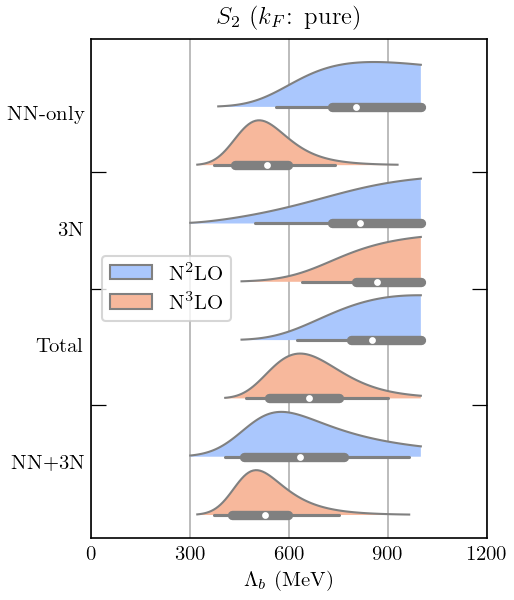

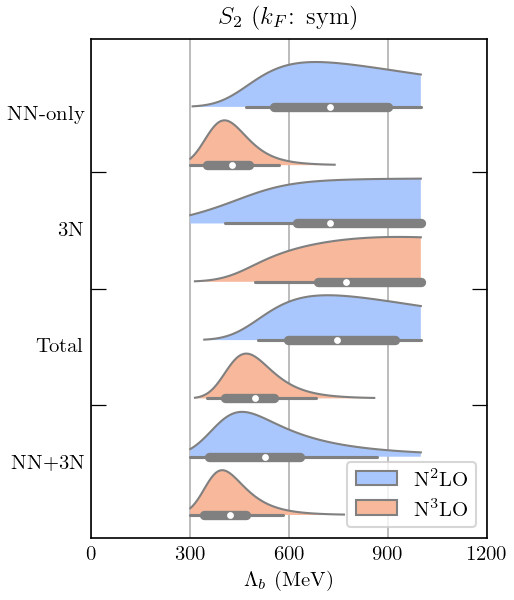

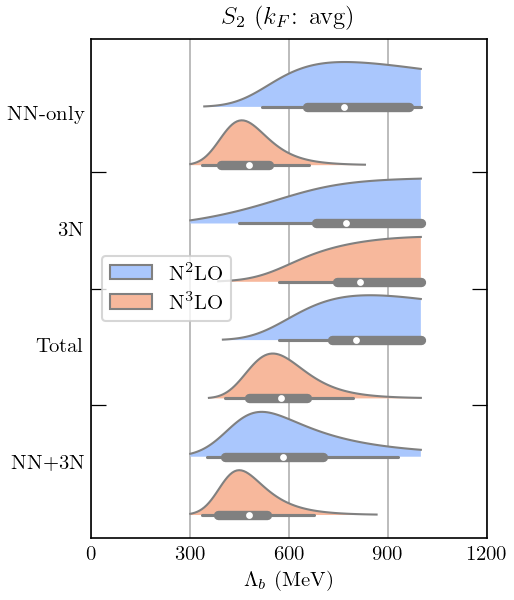

In [57]:
# lb_bodies = body_types[:-1]
lb_bodies = body_types

df_Lb_pdfs_n = create_breakdown_df(S2_analyses, lb_bodies, pure_neutron, kf_type_name='Pure')
df_Lb_pdfs_s = create_breakdown_df(S2_analyses, lb_bodies, sym_nuclear, kf_type_name='Nuclear')
df_Lb_pdfs_avg = create_breakdown_df(S2_analyses, lb_bodies, avg_momentum, kf_type_name='Avg')


df_Lb_pdf = pd.concat([df_Lb_pdfs_n, df_Lb_pdfs_s, df_Lb_pdfs_avg])


for kf_type, df_lb_i in zip(kf_types, [df_Lb_pdfs_n, df_Lb_pdfs_s, df_Lb_pdfs_avg]):
    fig, ax = plt.subplots(figsize=(3.4, 4.4))
    ax = pdfplot(
        x=r'$\Lambda_b$ (MeV)', y='Body', pdf='pdf', data=df_lb_i, hue='Order',
        order=[*lb_bodies[:-1], 'Total', lb_bodies[-1]], hue_order=[r'N$^2$LO', r'N$^3$LO'], cut=1e-2, linewidth=1,
            palette="coolwarm", saturation=1., ax=ax, margin=0.3,
    )
    ax.set_xlim(0, 1200)
    ax.set_xticks([0, 300, 600, 900, 1200])
    ax.grid(axis='x')
    ax.set_title(f'$S_2$ ($k_F$: {kf_type})')
    ax.set_axisbelow(True)
    plt.show()
    fig.savefig(f'S2_breakdown_{kf_type}')